<a href="https://colab.research.google.com/github/akankshakusf/Project-DeepLearning-Human-Emotions-Detection-Model/blob/master/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import packages
import numpy as np
from datetime import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
import sklearn
import cv2 #computer vision
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow packages
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Layer,Activation, MaxPooling2D, Add, Conv2D, MaxPool2D,GlobalAveragePooling2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,Lambda)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

# Define main_directory Structure

In [4]:
train_directory="/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# Params Dictionary

In [26]:

CONFIGURATION={
        "BATCH_SIZE":32,
        "IM_SIZE":256,
        "LEARNING_RATE":0.001,
        "N_EPOCHS":20,
        "DROPOUT_RATE":0.0,
        "REGULARIZATION_RATE":0.0,
        "N_FILTERS":6,
        "KERNEL_SIZE":3,
        "N_STRIDES":1,
        "POOL_SIZE":2,
        "N_DENSE_1":1024,
        "N_DENSE_2":128,
        "NUM_CLASSES":3,
        "CLASS_NAMES": ["angry", "happy", "sad"],
        "PATCH_SIZE":16
}

# Wandb Installation - ML ops

## Wandb Install,Login and Intialization

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: akushwaha2 (akankshakusf2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb

wandb.init(
    project="Human-Emotions-Detection",
    entity="akankshakusf2",
    #name = "confusionmatrix"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: akushwaha2 (akankshakusf2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from wandb.integration.keras import WandbCallback

In [ ]:
wandb.config = CONFIGURATION

# Data Management

## Data Downloading- Importing Kaggle Dataset

In [6]:
!pip install -q kaggle

In [7]:
import os
import zipfile

# Make a hidden .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown


In [9]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Dataset Loading

In [10]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=32,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [11]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

## Dataset Visualization

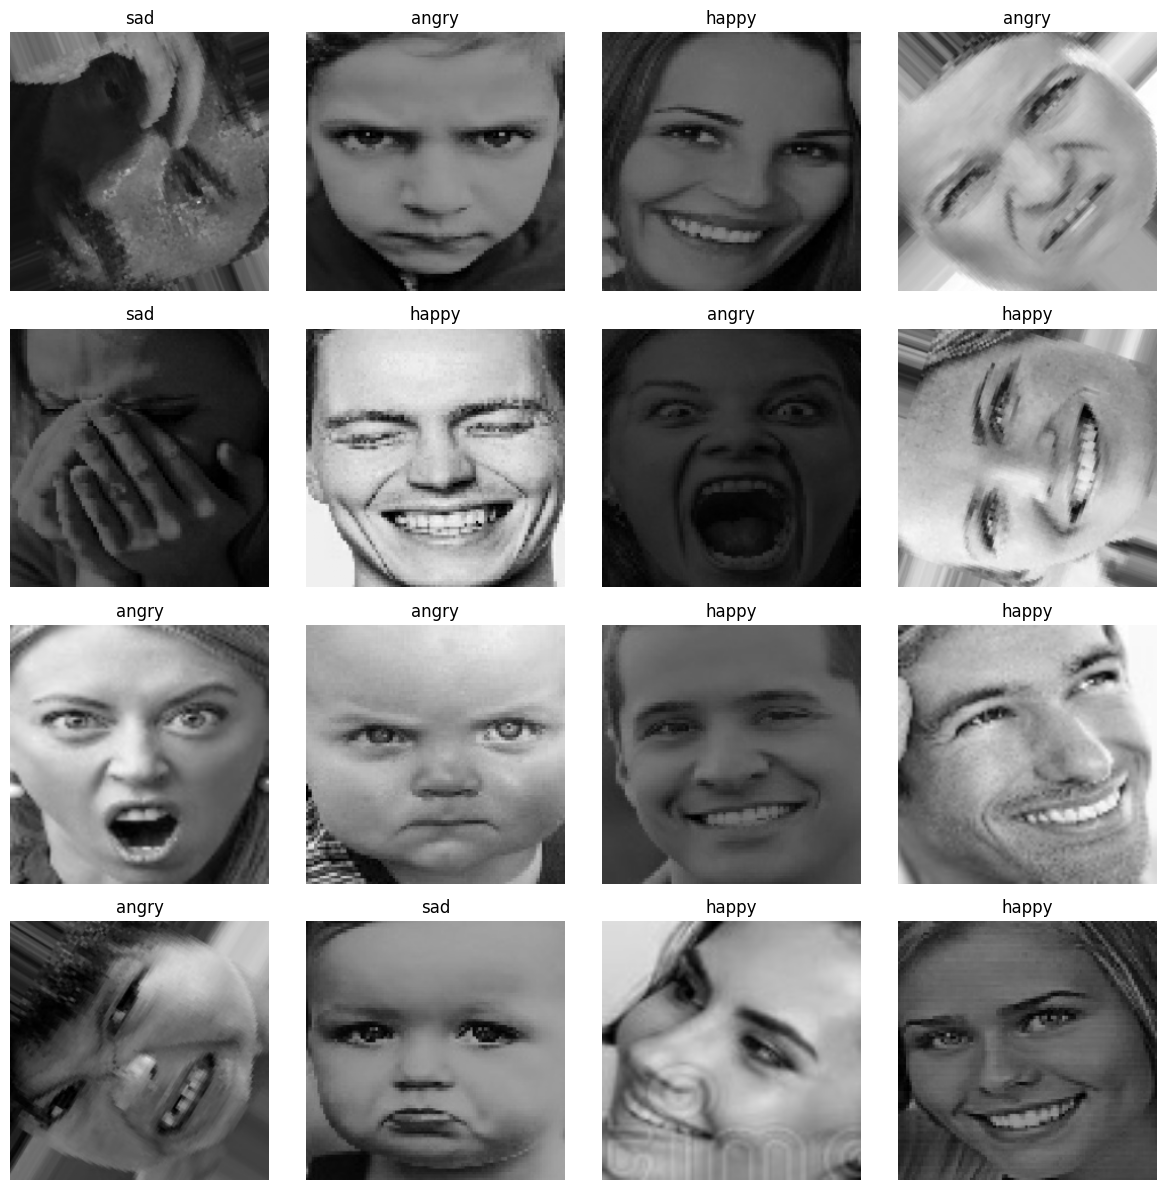

In [ ]:
# Get one batch
images, labels = next(iter(train_dataset))
plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy() / 255.0)  # normalize and convert tensor to numpy
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])  # convert one-hot to class index
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Augmentation

- reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [10]:
# 1.Augmented layer with "layers method" rotation/flip/contrast
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
])

In [11]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label

In [12]:
## 2.Augmented layer with "layers method" for resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1.0 / 255),
])

## CutMix Data Augmentation

In [ ]:
def box(lamda):

  # Randomly select a center point (x, y) for the patch within the image
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)

  # Calculate the width and height of the patch based on how much of the image we want to replace
  r_w = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)

  # Adjust the top-left corner so the patch stays within image boundaries
  r_x = tf.clip_by_value(r_x - r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #find the x,y bottom right
  x_b_r= tf.clip_by_value(r_x + r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #final value of r_w,r_h
  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  # Print the top-left corner (r_x, r_y) and size (r_w, r_h) of the patch to be cut and mixed
  return r_y, r_x, r_h, r_w

In [ ]:
# Create a method to perform MixUp by combining two training images

def cutmix(train_dataset_1, train_dataset_2):
  # Draw a random value from a Beta distribution to decide how much to mix two images
  lamda = tfp.distributions.Beta(0.2, 0.2)  ### 0.2 is a standard
  lamda = lamda.sample(1)[0]

  r_y,r_x, r_h, r_w = box(lamda)

  # Unpack images and labels from both datasets
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Cut a rectangular patch from image_2
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  # Place the cropped patch onto a blank canvas (same size as image) at a specific location
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Do the same crop and pad for image_1 (to subtract the patch area later)
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Replace the patch in image_1 with the patch from image_2
  image = image_1 - pad_1 + pad_2

  lamda= tf.cast(1-(r_w*r_h)/(CONFIGURATION['IM_SIZE']*CONFIGURATION['IM_SIZE']),dtype=tf.float32)
  label = lamda*tf.cast(label_1,dtype=tf.float32) + (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  # Return the mixed image and the label (currently label_1 only)
  return image, label

## Dataset Preparation

- let tf pre fetch batches in the background while the model is training on the current batch
- let tf automatically choose the optimal number of batches to prefetch based on system performance.

In [ ]:
# # create a mixed datasets
# train_dataset_1= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset_2= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)

# mixed_dataset=tf.data.Dataset.zip(train_dataset_1, train_dataset_2) # comment when using Albumentation

In [13]:
#prefetch and autotune
training_dataset=(train_dataset
               .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
               .prefetch(tf.data.AUTOTUNE))

In [ ]:
# # Training pipeline with augmentation
# train_dataset = (
#     mixed_dataset
#     .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
#     #.batch(CONFIGURATION['BATCH_SIZE'])
#     .prefetch(tf.data.AUTOTUNE)
# )

In [14]:
validation_dataset=(val_dataset
             .prefetch(tf.data.AUTOTUNE))

In [15]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [16]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modelling

## Simple Sequential LeNet Model

In [ ]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()


In [ ]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''

lenet_model = tf.keras.Sequential([

    #InputLayer(shape = (None, None, 3), ),
    InputLayer(input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),

    resize_rescale_layers, # embedding resize and rescale into SequentialAPI
    augment_layers,

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],
              strides=CONFIGURATION["N_STRIDES"]*2),  # Downsamples feature maps

    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),  # Downsampling again


    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),  # Fully connected layer
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),   # Further processing
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),     # Output layer (multi-class classification)

])

# Print model summary
lenet_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

## ResNet Model : Deep Residual Learning for Image Recognition

### CustomConv2D

In [ ]:
# Custom layer inherits from layers class
class CustomConv2D(Layer):
  def __init__(self,n_filters,kernel_size,n_strides,padding='valid'): #Constructor: defines the layers used in the model
    super(CustomConv2D,self).__init__(name='custom_conv2d')

    #combining Conv2D + ReLU + BatchNormalization
    self.conv=Conv2D(
        filters=n_filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=n_strides,
        padding=padding
    )

    self.batch_norm= BatchNormalization()

  def call(self,x,training=True):

    x=self.conv(x)
    x=self.batch_norm(x,training=training)

    return x

### Residual Block

In [ ]:
# My ResidualBlock custom class inherits from the "Layer" class
class ResidualBlock(Layer):
  def __init__(self,n_channels, n_strides=1):
    super(ResidualBlock,self).__init__(name="res_block")
    self.dotted = (n_strides != 1) # Shortcut projection needed when stride != 1

     # Main path
    self.custom_conv_1 = CustomConv2D(n_channels,3,n_strides,padding="same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding ="same")
    self.activation = Activation("relu")

     # Shortcut path (1x1 conv to match shape if stride != 1)
    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels,1,n_strides)


  def call(self,input,training=True):

    x=self.custom_conv_1(input,training=training)
    x=self.custom_conv_2(x,training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input,training=training)
      x_add = Add()([x,x_add])

    else:
      x_add= Add()([x,input])

    return self.activation(x_add)


### Complete Network

In [ ]:
# My ResNet34 custom class inherits from the Model class
class ResNet34(Model):
  def __init__(self,):# Constructor: defines the layers used in the model
    super(ResNet34,self).__init__(name='resnet_34')

    # Initial convolution and max pooling layers
    self.conv_1= CustomConv2D(64,7,2,padding='same')
    self.max_pool=MaxPooling2D(3,2)

    # Residual blocks for each stage of the network
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128,2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256,2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512,2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    # Global average pooling and final dense layer
    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')


  def call(self,x,training=True): # Forward pass: defines how input data flows through the model
    x=self.conv_1(x)
    x=self.max_pool(x)

    x=self.conv_2_1(x, training=training)
    x=self.conv_2_2(x, training=training)
    x=self.conv_2_3(x, training=training)

    x=self.conv_3_1(x, training=training)
    x=self.conv_3_2(x, training=training)
    x=self.conv_3_3(x, training=training)
    x=self.conv_3_4(x, training=training)

    x=self.conv_4_1(x, training=training)
    x=self.conv_4_2(x, training=training)
    x=self.conv_4_3(x, training=training)
    x=self.conv_4_4(x, training=training)
    x=self.conv_4_5(x, training=training)
    x=self.conv_4_6(x, training=training)

    x=self.conv_5_1(x, training=training)
    x=self.conv_5_2(x, training=training)
    x=self.conv_5_3(x, training=training)

    x= self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]),training=False)  # Force build with dummy input
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Modelling with Pre trained Models

### Transfer Learning with EfficientNet

* This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.

In [12]:
#Instantiates the EfficientNetB4 Model
backbone= tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3)
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
#disable backbone: for trainable we are not going to update the weight of the pretrained model
backbone.trainable=False

In [22]:
#Instantiating my pretrained model
pretrained_model =tf.keras.Sequential([
    Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation='relu'),
    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax'),
])
pretrained_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

### FineTuning with EfficientNet

In [ ]:
#enable backbone: for trainable we are going to update the weight of the pretrained model
backbone.trainable=True

In [ ]:
#Instantiating my fine tuning layers

input = Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

x = backbone(input, training= False) #setting training to false meaning use the same mean and std found training inputs training
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation='relu')(x)
x = BatchNormalization()(x) #this is running in inference mode now
x = Dense(CONFIGURATION["N_DENSE_2"], activation='relu')(x)

output = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)

#instantiate the model
finetined_model = Model(input, output)
finetined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

## Vision Transformers

### Patch Encoder

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105565.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

In [ ]:
#check the shape of test.image
print(test_image.shape)  ## we need to make it 4D,
print(tf.expand_dims(test_image, axis =0))
print((tf.expand_dims(test_image, axis =0)).shape)  ## i have added an extra dimension

(256, 256, 3)
tf.Tensor(
[[[[84 84 84]
   [85 85 85]
   [83 83 83]
   ...
   [ 8  8  8]
   [ 8  8  8]
   [ 8  8  8]]

  [[85 85 85]
   [86 86 86]
   [84 84 84]
   ...
   [ 8  8  8]
   [ 8  8  8]
   [ 9  9  9]]

  [[86 86 86]
   [87 87 87]
   [84 84 84]
   ...
   [11 11 11]
   [11 11 11]
   [11 11 11]]

  ...

  [[77 77 77]
   [77 77 77]
   [78 78 78]
   ...
   [ 4  4  4]
   [ 4  4  4]
   [ 3  3  3]]

  [[76 76 76]
   [77 77 77]
   [77 77 77]
   ...
   [ 5  5  5]
   [ 4  4  4]
   [ 3  3  3]]

  [[77 77 77]
   [77 77 77]
   [77 77 77]
   ...
   [ 5  5  5]
   [ 5  5  5]
   [ 4  4  4]]]], shape=(1, 256, 256, 3), dtype=uint8)
(1, 256, 256, 3)


reference= https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

In [ ]:
# ### this is code testing
# sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1]
# print(sizes)
# strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1]
# print(strides)
## this is fine !! but to this now we need to all 16*16*3 where 3 will be three channels RGB

In [ ]:
#patches will have no of dimensions through which this 16*16 image will be send to encoder
patches=tf.image.extract_patches(images=tf.expand_dims(test_image, axis =0),
                           sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
#check the patches shape
print(patches.shape)
# 1 image → 16 rows x 16 columns of patches → each patch is a vector of 768 values

(1, 16, 16, 768)


*Note : Looking at this shape (batch, 16, 16, patch_dim) (1, 16, 16, 768)  we can say that,
since we have IM_SIZE = 256, Then for the R,Y,B channels we will have
256X3 = 768.
This is how we have gotten that 4th dimension, that shows no. of dimensions this 16X16 will be represented

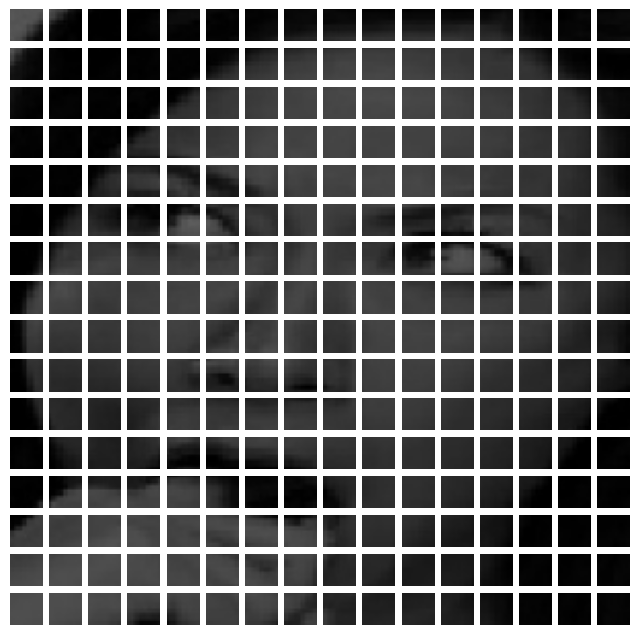

In [ ]:
#now to plot this we will go to each and every patch

plt.figure(figsize=(8, 8))

# Initialize a counter to keep track of the patches
k = 0
# Loop over 16 rows of patches
for i in range(16):
    # Loop over 16 columns of patches
    for j in range(16):
        # Create a subplot in a 16x16 grid layout, placing the current patch at position k+1
        ax = plt.subplot(16, 16, k + 1)

        # Take the k-th patch & flatten i.e reshape it back to a 16x16 RGB
        plt.imshow(tf.reshape(patches[0, i, j, :], (16, 16, 3)))
        plt.axis('off')

        # Move to the next patch
        k += 1

plt.show()

In [ ]:
#now change the shape of patches back to 256 (just combine 16X16)
patches = tf.reshape(patches, (1, 256, 768))
# same thing like above
##patches = tf.reshape(patches, (patches.shape[0],-1, 768))
print(patches.shape)

(1, 256, 768)


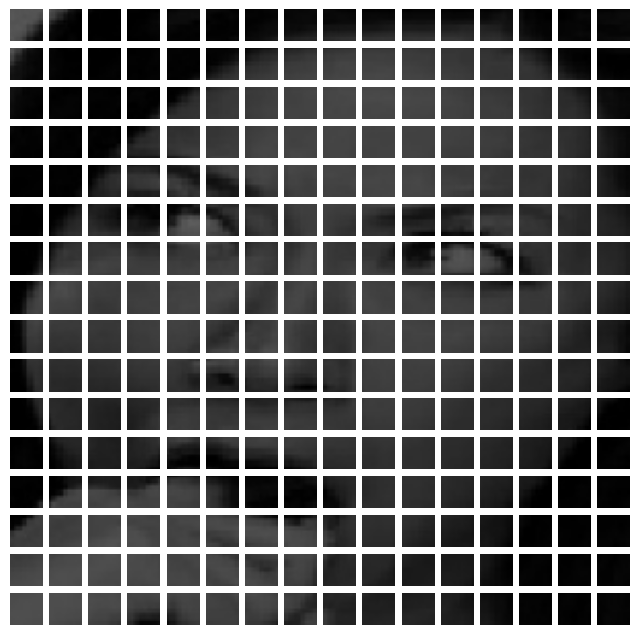

In [ ]:
#now plot these patches similar to above but like this (batch, 256, patch_dim)
plt.figure(figsize=(8,8))

k=0
for i in range(patches.shape[1]):
  ax = plt.subplot(16,16,i+1)
  # break down 768 = 16*16*3 → patch size of 16x16 pixels with 3 color channels (RGB)
  plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
  plt.axis('off')
  k+=1

plt.show()


*I am doing this
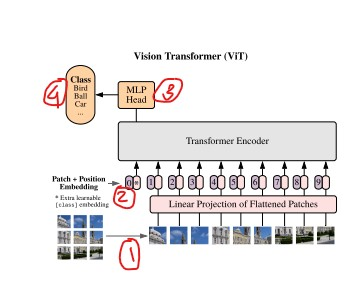

In [ ]:
#### Explaination of of how to generate :
# we want to make(B,Np,Hd) = (1,256,768)
# B = batches, Np: no of patches, Hd: hidden dimensions

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(256,768))
# input_array = np.random.randint(1000, size=(1, 256))
# model.compile('rmsprop', 'mse')
# output_array = model.predict(input_array)
# print(output_array.shape)

* Embedding reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* PatchEncoder splits the image into small patches and projects each patch into a fixed-sized vector (like an embedding).

In [ ]:
# My PatchEncoder custom class inherits from the Model class
class PatchEncoder(Layer):
  def __init__(self,N_PATCHES, HIDDEN_SIZE): #Constructor: defines the layers used in the model
    super(PatchEncoder,self).__init__(name='patch_encoder')

    ## refer diagram to understand better
    self.linear_projection=Dense(HIDDEN_SIZE)  #linear Projection
    self.positional_embedding=Embedding(N_PATCHES,HIDDEN_SIZE) #positional embedding
    self.N_PATCHES=N_PATCHES    # flatten patches

  def call(self,x): ## Forward pass: defines how input data flows through the model

    #step 1: Extracts patches from an input image. how done above
    patches=tf.image.extract_patches(
                           images=x,
                           sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

    # step 1: Flattens and reshapes them into vectors.  how done above
    patches = tf.reshape(patches, (tf.shape(patches)[0],256, patches.shape[-1]))

    embedding_input = tf.range(start=0, limit= self.N_PATCHES, delta=1)


    #step1: design output: Projects each patch into a high-dimensional vector space (using a linear layer)
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output


In [ ]:
#call the encoder function and test an image
patch_enc = PatchEncoder(N_PATCHES=256, HIDDEN_SIZE=768)

#dry run test the encoder with zeros
patch_enc(tf.zeros([1,256,256,3]))  ## 1:batch_size,256=height,256=width,3=channels

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.02295785, -0.02744012,  0.03797689, ...,  0.03056094,
         -0.00283534, -0.04493864],
        [-0.01190794,  0.03552595, -0.01502917, ..., -0.01030246,
          0.04330274, -0.04484986],
        [-0.01046766,  0.02864206,  0.02887825, ...,  0.02022736,
         -0.02511952, -0.01244062],
        ...,
        [-0.03142872, -0.00795681, -0.01583449, ...,  0.01730815,
          0.01539758, -0.03205041],
        [ 0.03716717, -0.02866966, -0.00799758, ..., -0.01846855,
          0.00610503,  0.01948048],
        [ 0.03867641, -0.04403033, -0.01969641, ..., -0.01604702,
         -0.00796076, -0.03457391]]], dtype=float32)>

Note : Observe the shape generated by the encoder.  shape=(1, 256, 768),
so, now the "Tranformer Encoder" in image is sending out 1 batch of 256 images that have 768 dimensional vectors embeddings

### Transformer Encoder

*Now I am building grey block as Embedded Patches are done:
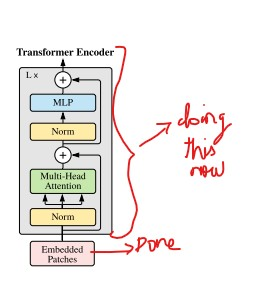

* MultiHeadAttention reference:https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention
*TransformerEncoder reference: https://www.tensorflow.org/api_docs/python/tfm/nlp/models/TransformerEncoder

In [ ]:
# My TransformerEncoder custom class inherits from the layer class
class TransformerEncoder(Layer):
  def __init__(self,N_HEADS, HIDDEN_SIZE): #Constructor: defines the layers used in the model
    super(TransformerEncoder,self).__init__(name='transformer_encoder')

    # 2 layer Normalization blocks
    self.layer_norm_1=LayerNormalization()
    self.layer_norm_2=LayerNormalization()


    #one multihead block
    self.multi_head_att=MultiHeadAttention(N_HEADS,HIDDEN_SIZE )

    # MLP block has 2 fully connected dense layers
    self.dense_1=Dense(HIDDEN_SIZE,activation=tf.nn.gelu) #gelu as it used in the research paper
    self.dense_2=Dense(HIDDEN_SIZE,activation=tf.nn.gelu)

  def call(self,input): #set up call for all layers

    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    # Add input back to the MHA output (residual connection)
    x_1= Add()([x_1,input])

    x_2 = self.layer_norm_2(x_1)

    #MLP has 2 dense layers
    x_2 = self.dense_1(x_2)
    output = self. dense_2(x_2)

    # Add input back to the MLP output (residual connection)
    output = Add()([output,x_1])

    return output

In [ ]:
#call the encoder function and test an image
trans_enc = TransformerEncoder(N_HEADS=8, HIDDEN_SIZE=768)

#dry run test the encoder with zeros
trans_enc(tf.zeros([1,256,768]))  ## 1:batch,256=height,768=dimensions

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

* Here I will make use of PatchEncoder and TransformerEncoder defined above"

In [ ]:
# My Vision Transformer Model custom class inherits from the Model class
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):# Constructor: defines the layers used in the model
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS

    # patch encoder
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    # since there will be L X layers of transformer_encoder, quick check on diagram helps
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    #MLP block has dense layer
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')


  def call(self, input, training = True):# Forward pass: defines how input data flows through the model

    x = self.patch_encoder(input)

    #looping through all transformer encoder layers
    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
#call the encoder function and test an image
vit = ViT(N_HEADS = 4,HIDDEN_SIZE = 768,N_PATCHES= 256,N_LAYERS=2,N_DENSE_UNITS=1028)

#dry run test the encoder with zeros
vit(tf.zeros([1,256,256,3])) # 3 means channels

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.40502304, 0.3503665 , 0.24461049]], dtype=float32)>

In [ ]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)         │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (1, 1028)                   │     202,114,052 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (1, 1028)                   │       1,057,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (1, 3)                      │           3,087 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,224,999 (859.17 MB)

 Trainable params: 225,224,999 (859.17 MB)

 Non-trainable params: 0 (0.00 B)

## HuggingFace ViT

* TFViTForImageClassification reference : https://huggingface.co/docs/transformers/en/model_doc/vit#transformers.TFViTForImageClassification
* understamd epsilon : https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization - Small float added to variance to avoid dividing by zero. Defaults to 1e-3."

### Installation

In [ ]:
!pip install transformers

* reference : https://huggingface.co/docs/transformers/en/model_doc/vit#transformers.ViTConfig

#### Working HF Code

In [ ]:
# # 1. Preprocessing function
# def preprocess(x):
#     x = tf.image.resize(x/255., [224,224])  ## Resize image to 224x224
#     x = (x - [0.485,0.456,0.406])/[0.229,0.224,0.225]  ## Normalize the image using ImageNet's mean and std values
#     return tf.transpose(x, perm=[0,3,1,2])  # Channels-first

In [ ]:
# # 2. ViT Wrapper that handles Keras tensors
# class ViTWrapper(tf.keras.layers.Layer):
#     def __init__(self, vit_model, **kwargs):
#         super().__init__(**kwargs)
#         self.vit = vit_model

#     def call(self, inputs):
#         # Convert Keras tensor to concrete tensor
#         outputs = self.vit(pixel_values=inputs)
#         return outputs.last_hidden_state[:,0,:]

In [ ]:
# # 3. Build Model
# from transformers import TFViTModel

# vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# vit_model.trainable = False

# inputs = Input(shape=(256, 256, 3))
# x = Lambda(preprocess, output_shape=(3,224,224))(inputs)
# x = ViTWrapper(vit_model)(x)
# outputs = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)
# hf_model = Model(inputs, outputs)


In [ ]:
# # 4. Print Summary
# vit_params = sum(tf.size(w).numpy() for w in vit_model.weights)
# dense_params = sum(tf.size(w).numpy() for w in hf_model.layers[-1].weights)

In [ ]:
# print(f"\n{' MODEL SUMMARY ':=^60}")
# print(f"{'Total params:':<20} {vit_params + dense_params:,}")
# print(f"{'Trainable params:':<20} {dense_params:,}")
# print(f"{'Non-trainable params:':<20} {vit_params:,}")
# print("="*60)
# print(f"{'Layer':<15} {'Output Shape':<20} {'Params':>10}")
# print("-"*60)
# print(f"{'Input':<15} (None,256,256,3) {'0':>10}")
# print(f"{'Preprocess':<15} (None,3,224,224) {'0':>10}")
# print(f"{'ViT':<15} (None,768) {f'{vit_params:,}':>10}")
# print(f"{'Output':<15} (None,5) {f'{dense_params:,}':>10}")

In [ ]:
# test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
# # Resize to the input size expected by the model
# test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

# #expand dims to display
# hf_model(tf.expand_dims(test_image, axis = 0))

### Training

In [ ]:
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="google/vit-base-patch16-224")

In [ ]:
from transformers import TFViTModel
import re

In [ ]:
# class TrainableViTWrapper(Layer):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         # Load ViT HF model
#         self.vit = TFViTModel.from_pretrained("google/vit-base-patch16-224")
#         self.vit.trainable = True

#         # Preprocessing layers
#         self.resize = tf.keras.layers.Resizing(224, 224)
#         self.normalize = tf.keras.layers.Lambda(
#             lambda x: (x / 127.5) - 1.0  # Convert to [-1, 1] range
#         )

#     def call(self, inputs):
#         # Preprocessing pipeline
#         x = self.resize(inputs)
#         x = self.normalize(x)
#         x = tf.transpose(x, [0, 3, 1, 2])  # NHWC to NCHW
#         return self.vit(pixel_values=x).last_hidden_state[:, 0, :]

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], 768)

# # Build model
# inputs = Input(shape=(256, 256, 3))
# features = TrainableViTWrapper()(inputs)
# outputs = Dense(3, activation='softmax')(features)
# hf_model = Model(inputs, outputs)

In [ ]:
### TESTING
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable
from transformers import TFViTModel

@register_keras_serializable()
class TrainableViTWrapper(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained("google/vit-base-patch16-224", from_pt=True)
        self.vit.trainable = True
        self.resize = tf.keras.layers.Resizing(224, 224)
        self.normalize = tf.keras.layers.Rescaling(1./255)

    def call(self, inputs):
        x = self.resize(inputs)  # (None, 224, 224, 3)
        x = self.normalize(x)
        x = tf.transpose(x, perm=[0, 3, 1, 2])  #Now it's (None, 3, 224, 224)
        outputs = self.vit(pixel_values=x, training=True)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

# Build model
inputs = Input(shape=(256, 256, 3))
features = TrainableViTWrapper()(inputs)
outputs = Dense(3, activation='softmax')(features)  #3 emotion classes
hf_model = Model(inputs, outputs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Took this code from github

In [ ]:
# Manually register ViT weights with the model
for weight in hf_model.layers[1].vit.weights:
    # Clean the weight name
    clean_name = re.sub(r'[:/]', '_', weight.name)
    hf_model.add_weight(
        name=f"vit_{clean_name}",
        shape=weight.shape,
        dtype=weight.dtype,
        initializer=tf.keras.initializers.Constant(weight.numpy()),
        trainable=True
    )

In [ ]:
# dry run with random data
dummy_input = np.random.rand(1, 256, 256, 3).astype(np.float32)
_ = hf_model.predict(dummy_input)
print(_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.30440533 0.49936482 0.19622983]]


In [ ]:
# Now model.summary() will show all parameters correctly
print("MODEL SUMMARY:")
hf_model.summary(show_trainable=True)

MODEL SUMMARY:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ trainable_vi_t_wrapper              │ (None, 768)                  │             0 │    -    │
│ (TrainableViTWrapper)               │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 3)                    │         2,307 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 86,391,555 (329.56 MB)

 Trainable params: 86,391,555 (329.56 MB)

 Non-trainable params: 0 (0.00 B)

- Running a check to confirm all parameters are getting trained

In [ ]:
for layer in hf_model.layers:
    print(layer.name, layer.trainable)

trainable_vars = [v.name for v in hf_model.trainable_weights]
print("Trainable vars:", trainable_vars)

input_layer_1 True
trainable_vi_t_wrapper True
dense True
Trainable vars: ['vit_tf_vi_t_model_vit_embeddings_cls_token_0', 'vit_tf_vi_t_model_vit_embeddings_position_embeddings_0', 'vit_tf_vi_t_model_vit_embeddings_patch_embeddings_projection_kernel_0', 'vit_tf_vi_t_model_vit_embeddings_patch_embeddings_projection_bias_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_query_kernel_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_query_bias_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_key_kernel_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_key_bias_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_value_kernel_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_value_bias_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_output_dense_kernel_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_attention_output_dense_bias_0', 'vit_tf_vi_t_model_vit_encoder_layer_._0_intermediate_dense_kernel_0'

# Model Training

## Training with Class Weighing

- We can see very clearly from the confusion matrix that model is more dominant towards happy images and sad images  since it has been trained more on the happy , sad samples so we will be now trying to penalize the model more on the wrong angry predictions compared to penalizining when it makes a wrong happy face prediction.

In [ ]:
n_sample_0 =1525 #angry
n_sample_1 = 3019 #happy
n_sample_2 = 2255 #sad

In [ ]:
print(1525+3019+2255)

6799


In [ ]:
class_weights = {0:6799/n_sample_0, 1:6799/n_sample_1, 2:6799/n_sample_2}

In [ ]:
print(class_weights)

{0: 4.458360655737705, 1: 2.2520702219277906, 2: 3.015077605321508}


* from here we can conclude that the model has more weight for the sad class : Meaning it will make more mistakes while predicting Sad faces

## Callbacks

In [ ]:
# ModelCheckpoint
checkpoint_callback=ModelCheckpoint(
    filepath='weights.{epoch:02d}--{val_loss:.2f}.keras',
    monitor='val_accuracy',
    verbose=True,
    save_best_only=True,
    #save_weights_only=False,
)

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    #iterate through the validation ds
    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    # predicted and true values
    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])#what model predicted
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])#true values

    # reference : https://docs.wandb.ai/guides/track/log/plots/ : find under Model evaluation charts
    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})



In [ ]:
# ### TESTING CODE
# fake_output = tf.constant([[0.1, 0.3, 0.6],  [0.5, 0.3, 0.2],  [0.1, 0.8, 0.1]   ], dtype=tf.float32)

# # label mapping
# CLASS_NAMES = ["Happy", "Sad", "Angry"]

# # 3. Convert to NumPy to inspect actual probabilities
# probabilities = fake_output.numpy()
# print(f"probabilities:{probabilities}")

# # 4. Use argmax get max prob class
# predicted_indices = tf.argmax(fake_output, axis=-1).numpy()
# print(f"predicted_indices:{predicted_indices}")    # take a look how argmax output looks

# # 5. Map predicted indices to human-readable class names
# predicted_labels = [CLASS_NAMES[i] for i in predicted_indices]

# # 6. Print results clearly
# print("=== Model Prediction Summary ===\n")
# for i, (probs, label) in enumerate(zip(probabilities, predicted_labels), 1):
#     print(f"Sample {i}:")
#     print(f"  Probabilities → {probs}")
#     print(f"  Predicted Class → {label}\n")



probabilities:[[0.1 0.3 0.6]
 [0.5 0.3 0.2]
 [0.1 0.8 0.1]]
predicted_indices:[2 0 1]
=== Model Prediction Summary ===

Sample 1:
  Probabilities → [0.1 0.3 0.6]
  Predicted Class → Angry

Sample 2:
  Probabilities → [0.5 0.3 0.2]
  Predicted Class → Happy

Sample 3:
  Probabilities → [0.1 0.8 0.1]
  Predicted Class → Sad



reference : https://docs.wandb.ai/guides/track/log/log-tables/

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]  # see argmax example in above cell
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})

## Training

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

* Compile the Resnet Model

In [ ]:
#compile the model
hf_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics)

In [ ]:
#fit the model
history=hf_model.fit(
    train_dataset.take(20),
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[WandbCallback(log_model=False, log_graph=False, save_graph=False, save_model=False)
               #,LogConfMatrix()
               ]
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['functional_1/vit_tf_vi_t_model_vit_embeddings_cls_token_0', 'functional_1/vit_tf_vi_t_model_vit_embeddings_position_embeddings_0', 'functional_1/vit_tf_vi_t_model_vit_embeddings_patch_embeddings_projection_kernel_0', 'functional_1/vit_tf_vi_t_model_vit_embeddings_patch_embeddings_projection_bias_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_query_kernel_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_query_bias_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_key_kernel_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_key_bias_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_value_kernel_0', 'functional_1/vit_tf_vi_t_model_vit_encoder_layer_._0_attention_attention_value_bias_0', 'functional_1/vit_tf_vi_t_m

20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.4713 - loss: 1.1672 - top_k_accuracy: 0.7478 - val_accuracy: 0.6172 - val_loss: 0.8479 - val_top_k_accuracy: 0.8578
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.6607 - loss: 0.7790 - top_k_accuracy: 0.8893 - val_accuracy: 0.6866 - val_loss: 0.7132 - val_top_k_accuracy: 0.8977
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7140 - loss: 0.6383 - top_k_accuracy: 0.9232 - val_accuracy: 0.7063 - val_loss: 0.6742 - val_top_k_accuracy: 0.9034
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7408 - loss: 0.6029 - top_k_accuracy: 0.9511 - val_accuracy: 0.7221 - val_loss: 0.6474 - val_top_k_accuracy: 0.9113
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7861 - loss: 0.5299 - top_k_accuracy: 0.9375 - val_accuracy: 0.7278 - val_loss: 0.6434 - val_top_k_accuracy: 0.9078
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7941 - loss: 0.5370 - top_k_accuracy: 0.9312 - 

* Compile Efficient Net Model

In [ ]:
#compile the model
pretrained_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics)

In [ ]:
#fit the model with class balancing
history_p = pretrained_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,#CONFIGURATION["N_EPOCHS"],
    verbose=True,
    class_weight = class_weights,
    #callbacks =[checkpoint_callback]
    )

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 155s 522ms/step - accuracy: 0.6168 - loss: 3.4557 - top_k_accuracy: 0.8696 - val_accuracy: 0.7335 - val_loss: 0.6902 - val_top_k_accuracy: 0.9004
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 67s 315ms/step - accuracy: 0.7466 - loss: 1.9078 - top_k_accuracy: 0.9300 - val_accuracy: 0.7757 - val_loss: 0.5964 - val_top_k_accuracy: 0.9267
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 73s 273ms/step - accuracy: 0.7948 - loss: 1.5806 - top_k_accuracy: 0.9465 - val_accuracy: 0.7853 - val_loss: 0.5330 - val_top_k_accuracy: 0.9355
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 87s 298ms/step - accuracy: 0.8260 - loss: 1.3251 - top_k_accuracy: 0.9562 - val_accuracy: 0.7858 - val_loss: 0.5206 - val_top_k_accuracy: 0.9390
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 304ms/step - accuracy: 0.8406 - loss: 1.1943 - top_k_accuracy: 0.9589 - val_accuracy: 0.7893 - val_loss: 0.5228 - val_top_k_accuracy: 0.9394
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 81s 300ms/step - accuracy: 0.8505 

# Model Evaluation

In [ ]:
# lets load the best model
hf_model.load_weights("best_weights")

In [ ]:
#evaluate model on val data
hf_model.evaluate(val_dataset)

2278/2278 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7322 - loss: 0.6359 - top_k_accuracy: 0.9056


[0.6356315016746521, 0.730026364326477, 0.9179104566574097]

In [ ]:
#evaluate model on val data
pretrained_model.evaluate(val_dataset)

# Model Testing

- 1. testing for happy image

In [ ]:
#test an image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
# Convert the image to tensors
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape) # but this needs to be 4 dimensional


#adding batch dimension to shape [1, height, width, channels])
im = tf.expand_dims(im, axis=0)
print(im.shape)

#get predictions (argmax: get max probabilities)
predictions= hf_model(im)
print(hf_model(im))
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(predictions, axis=-1).numpy()[0]])

(256, 256, 3)
(1, 256, 256, 3)
tf.Tensor([[0.24889405 0.00994332 0.7411626 ]], shape=(1, 3), dtype=float32)
sad


- 2. testing for sad image

In [ ]:
#test an image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105565.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
# Convert jpg to tensors
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape) # but this needs to be 4 dimensional

#adding batch dimension to shape [1, height, width, channels])
im = tf.expand_dims(im, axis=0)
print(im.shape)

#get predictions (argmax: get max probabilities)
predictions= hf_model(im)
print(hf_model(im))
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(predictions, axis=-1).numpy()[0]])

(256, 256, 3)
(1, 256, 256, 3)
tf.Tensor([[0.52233535 0.02620527 0.4514593 ]], shape=(1, 3), dtype=float32)
angry


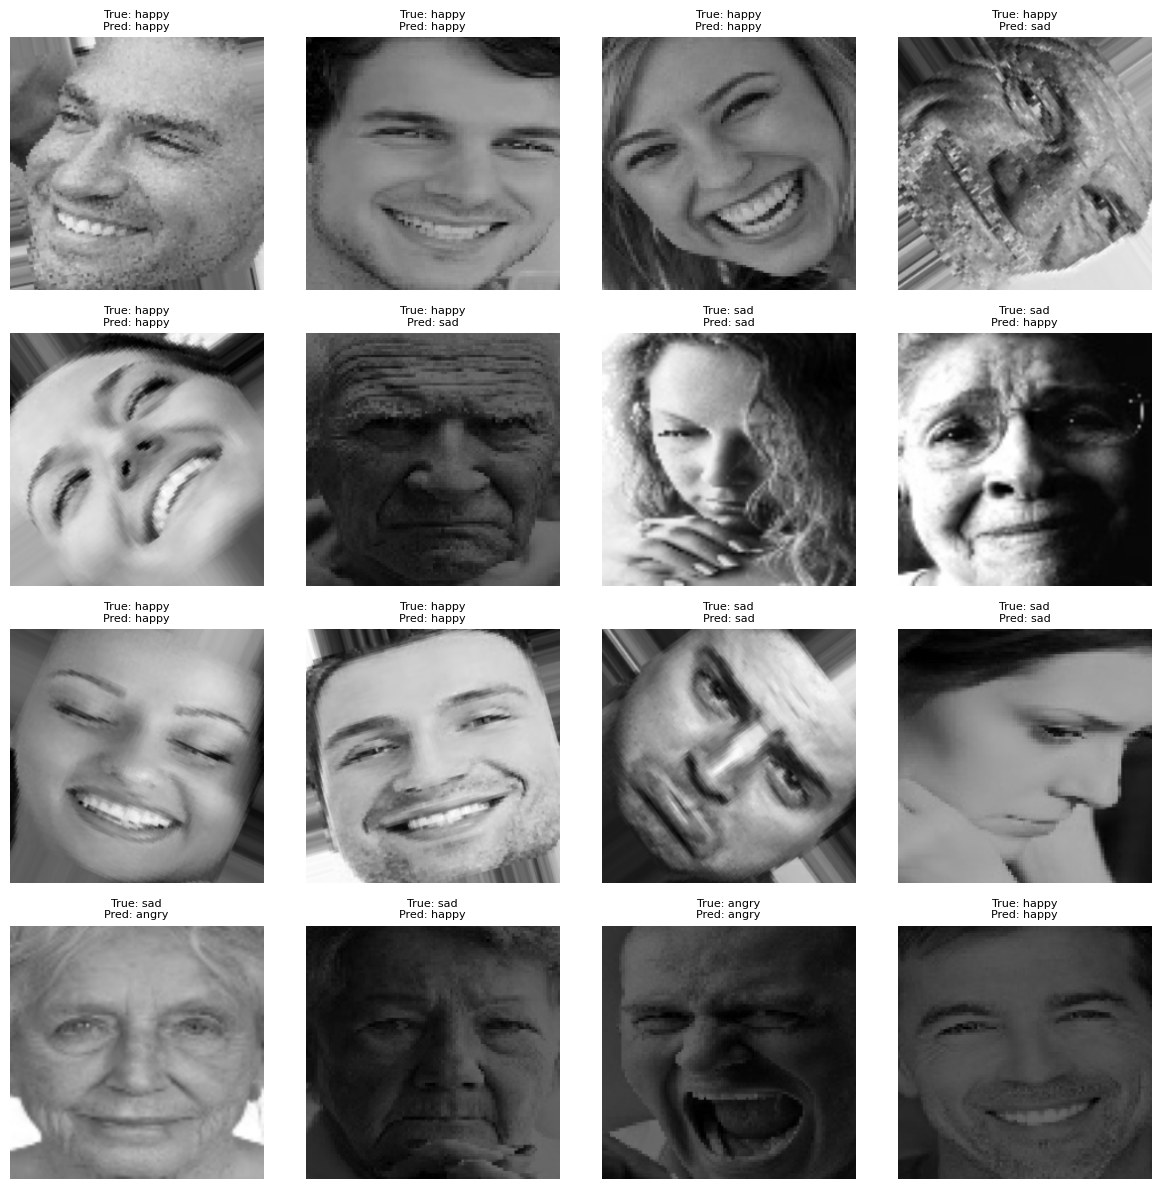

In [ ]:
# Collect 16 images manually
images = []
labels = []

for img_batch, label_batch in validation_dataset:
    images.append(img_batch[0])
    labels.append(label_batch[0])
    if len(images) == 16:
        break

plt.figure(figsize=(12, 12))

for i in range(16):
    image = images[i]
    label = labels[i]

    prediction = hf_model(tf.expand_dims(image, axis=0))
    predicted_label = tf.argmax(prediction, axis=-1).numpy()[0]
    true_label = tf.argmax(label, axis=0).numpy()

    plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy() / 255.0)
    plt.axis('off')
    plt.title(f"True: {CONFIGURATION['CLASS_NAMES'][true_label]}\nPred: {CONFIGURATION['CLASS_NAMES'][predicted_label]}", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# # Get one batch
# images, labels = next(iter(validation_dataset))
# plt.figure(figsize=(9, 9))

# # Since your batch size is 1, access the single image in the batch
# image = images[0]
# label = labels[0]

# plt.imshow(image.numpy() / 255.0)  # normalize and convert tensor to numpy

# # Update the title to use the single label and prediction
# plt.title("True Labels: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis=0).numpy()] + "\n" +
#           "Predicted Labels: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(tf.expand_dims(image, axis=0)), axis=-1).numpy()[0]])

# plt.tight_layout()
# plt.show()

In [ ]:
14/16

# Visualization

## VGG16- Visualization with Pre Trained Models

In [ ]:
vgg_backbone=tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3) #The default input size for this model is 224x224.
)

In [ ]:
vgg_backbone.summary()

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)] #am picking all layes where "conv" is present

#model that shows all hidden layes
feature_maps_model= Model(
    inputs=vgg_backbone.input,
    outputs=feature_maps,
    name='feature_maps'
)
feature_maps_model.summary()

- lets pass an image to this VGG model

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_maps_model.predict(im)

In [ ]:
print(len(f_maps))

In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)  ## see now we have only choosen layers

In [ ]:
# for i in range(len(f_maps)):
#   plt.figure(figsize=(256,256))
#   f_size=f_maps[i].shape[1] #no of filters
#   n_channels= f_maps[i].shape[3]  #no of channels
#   joint_maps= np.ones((f_size,f_size*n_channels))

#   axs= plt.subplot(len(f_maps),1,i+1)
#   for j in range(n_channels):
#     # ":"  means all 256, f_size*j means 0 to 1 i.e f_size*(j+1) 256
#     joint_maps[:,f_size*j:f_size*(j+1)] = f_maps[i][..., j]

#   plt.imshow(joint_maps[0:512])
#   plt.axis('off')
#   plt.show()




In [ ]:
import math

for i in range(len(f_maps)):
    fmap = f_maps[i][0]  # Assuming batch size is 1; shape: (H, W, C)
    n_channels = fmap.shape[-1]
    grid_size = int(math.ceil(math.sqrt(n_channels)))  # Make a square grid

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.suptitle(f"Feature Maps - Layer {i}", fontsize=16)

    for j in range(grid_size * grid_size):
        row, col = divmod(j, grid_size)
        ax = axs[row, col]
        if j < n_channels:
            ax.imshow(fmap[..., j], cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## GradCam- Visualization with Pre Trained Models

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
#test an image
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg" # Correctly assign the image path to img_path
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
print(preds)

In [ ]:
np.argmax(preds[0])

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

In [ ]:
#pick all last classifier layers from bottom
classifier_layer_name = [
    "global_average_pooling2d",
    "dense",
    "dense_1",
    "dense_2"
]

In [ ]:
classifier_input = Input(shape=(7,7,2048)) # Change the input shape to (7, 7, 2048)
x = classifier_input

for layer_name in classifier_layer_name:
  x = pretrained_model.get_layer(layer_name)(x)

classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  # Watch the input tensor for gradient calculation
  tape.watch(img_array)

  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output) # Calculate preds inside the GradientTape, using the output from the layer for which we need the gradients
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pool_grad= tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pool_grad.shape)

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[..., i] *= pool_grad[i]

In [ ]:
print(last_conv_layer_output.shape)

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv2.resize(heatmap.numpy(),(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.matshow(resized_heatmap*255 + img_array[0,:,:,0].numpy()/255)

In [ ]:
resized_heatmap=cv2.resize(heatmap.numpy(),(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.matshow(resized_heatmap*255 + img_array[0,:,:,0].numpy()/255)

## Vizualizing Accuracy and Losses

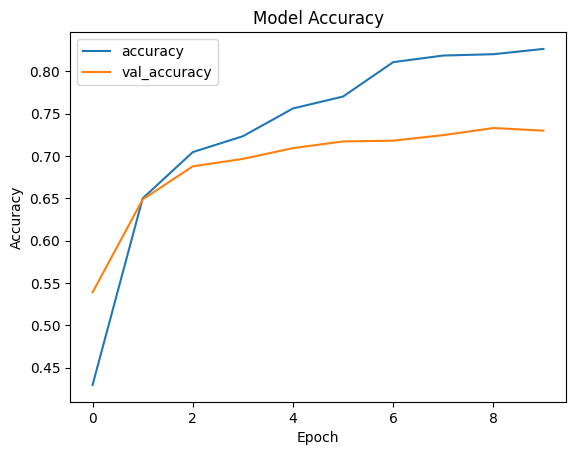

In [ ]:
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

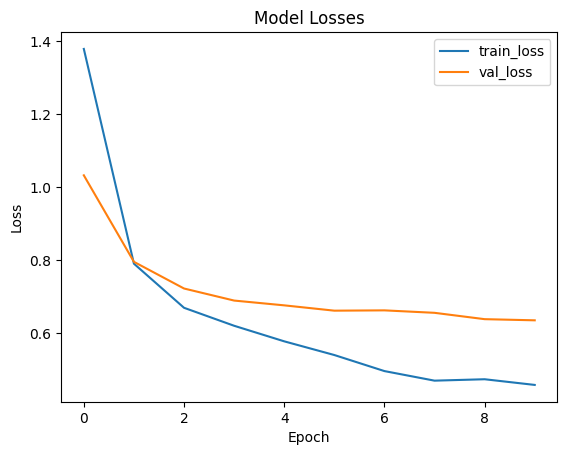

In [ ]:
# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# Exporting to Onnx format

In [ ]:
pretrained_model.save("vit_finetuned.keras")

In [ ]:
model = tf.keras.models.load_model("vit_finetuned.keras")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'trainable_vi_t_

In [ ]:
model.export("vit_finetuned")

Saved artifact at 'vit_finetuned'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136361077859024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077860560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077860752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077859792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077864208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077864784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077862288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077860176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077862096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077862480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136361077861904:

## Installation

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import onnxruntime as rt
rt.get_device()

'GPU'

## Conversion

### From TensorFlow SavedModel

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

2025-04-07 17:08:59.840245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744045739.873314    6838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744045739.884081    6838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 17:08:59.914580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but pri

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3),
    tf.float32,name="input"),)

output_path = "vit.keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(hf_model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['dense']


## Inference

In [ ]:
#test an image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105565.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
# Convert the image to tensors
im = test_image.astype(np.float32)
# print(im.shape) # but this needs to be 4 dimensional


#adding batch dimension to shape [1, height, width, channels])
im = np.expand_dims(im, axis=0)
print(hf_model(im))
print(im.shape)


tf.Tensor([[0.52233535 0.02620527 0.4514593 ]], shape=(1, 3), dtype=float32)
(1, 256, 256, 3)


In [ ]:
providers = ['CPUExecutionProvider']
m= rt.InferenceSession(output_path, providers= providers)
t1 = time.time()
onnx_pred = m.run(output_names,{"input":im})
print(time.time()- t1)

0.5606818199157715


In [ ]:
print(onnx_pred)

[array([[0.5223392 , 0.02620527, 0.4514555 ]], dtype=float32)]


In [ ]:
#[[0.52233535 0.02620527 0.4514593 ]]-->hf_model pred

In [ ]:
import time

In [ ]:
t1 = time.time()
hf_model(im)
print(time.time() - t1)

0.3374602794647217


In [ ]:
rt.get_device()

'GPU'

In [ ]:
# tf, gpu = 0.34s
# tf, cpu =

# onnx, gpu = 0.56s #CPUExecutionProvider
# onnx, gpu = 0.39s #CUDAExecutionProvider

### Benchmarking Onnx

In [ ]:
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
m= rt.InferenceSession(output_path, providers= providers)
t1 = time.time()
onnx_pred = m.run(output_names,{"input":im})
print(time.time()- t1)

0.39613962173461914


In [ ]:
# ONNX  testing : we can also measure the for a couple images  in a range
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
m= rt.InferenceSession(output_path, providers= providers)
t1 = time.time()
N_PREDICTIONS = 100
for _ in range(N_PREDICTIONS):
  onnx_pred=m.run(output_names,{'input':im})
print("Time for a single prediction",(time.time()- t1)/N_PREDICTIONS) #is average time pre image

Time for a single prediction 0.023157227039337158


By This we can see that Onnx is much faster than
- speedup = TF_time / ONNX_time
- speedup = 0.317 / 0.023 ≈ 13.78x

### Benchmarking TF

In [ ]:
# TF  testing : we can also measure the for a couple images  in a range
t1 = time.time()
N_PREDICTIONS = 100
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single prediction",(time.time()- t1)/N_PREDICTIONS) #is average time pre image

Time for a single prediction 0.31789057970046997


# Quantization with Onnx

Reference: https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/vit.keras.onnx'  # keras model saved previously
model_quant = '/content/vit_quantized.onnx' #quantize model

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

In [ ]:
# ONNX  testing : for vit_quantized model file
providers = ['CPUExecutionProvider']
m= rt.InferenceSession("/content/vit_quantized.onnx", providers= providers)
t1 = time.time()
N_PREDICTIONS = 100
for _ in range(N_PREDICTIONS):
  onnx_pred=m.run(output_names,{'input':im})
print("Time for a single prediction",(time.time()- t1)/N_PREDICTIONS) #is average time pre image

Time for a single prediction 0.3662227058410645


In [ ]:
# ONNX  testing : for vit.keras model file
providers = ['CPUExecutionProvider']
m= rt.InferenceSession("/content/vit.keras.onnx", providers= providers)
t1 = time.time()
N_PREDICTIONS = 100
for _ in range(N_PREDICTIONS):
  onnx_pred=m.run(output_names,{'input':im})
print("Time for a single prediction",(time.time()- t1)/N_PREDICTIONS) #is average time pre image

Time for a single prediction 0.4271396636962891


- The Model has reduced signficantly in size is sized down from 327.79 MB to 83.41MB and computation time is also good :  Time for a single prediction came down from 0.427 to 0.366

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset.take(100):
    onnx_pred=model.run(output_names, {"input":np.array(im)})

    if(int(np.argmax(onnx_pred,axis=-1)[0][0])== int(np.argmax(label,axis=-1)[0])):
      acc +=1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/vit.keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.31
0.3


# Quantization in TensorFlow

### Installation and Import

In [15]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.2 MB/s eta 0:00:00


In [16]:
import tensorflow_model_optimization as tfmot

## Quantization Aware Training

In [24]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_14 (Rescaling)  │ (None, 256, 256, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_7           │ (None, 256, 256, 3)    │              7 │ rescaling_14[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_15 (Rescaling)  │ (None, 256, 256, 3)    │              0 │ normalization_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_15[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,660,841 (71.19 MB)

 Trainable params: 18,534,610 (70.70 MB)

 Non-trainable params: 126,231 (493.09 KB)

In [25]:
pretrained_model.summary()

NameError: name 'pretrained_model' is not defined

In [28]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [29]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model,
    clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_eff.summary()

# Post Training Quantization : imp for mobiles

In [ ]:
#evaluate model on val data
pretrained_model.evaluate(val_dataset)

2278/2278 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.8182 - loss: 0.4939 - top_k_accuracy: 0.9480


[0.5092867612838745, 0.8151887655258179, 0.9495171308517456]

In [ ]:
pretrained_model.save("eff_net.keras")

In [ ]:
# lets load the best model
pretrained_model.load_weights("eff_net.keras")

- Reference : https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter

In [ ]:
def representative_dataset_gen():
  for input_value,j in training_dataset.take(2):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen

In [ ]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmplhiah__q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_479')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138518772380304: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138518772380880: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138520240087184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240087952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240087760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240087376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240089104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240090640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240090256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138520240091600: TensorSpec(shape=(), dtype=tf.resource, name=

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir / "eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)


22148856

### TFLIte Runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


In [ ]:
import tflite_runtime as tflite

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
print(test_image.dtype)

# print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(test_image), axis = -1).numpy()[0]])

In [ ]:
import tflite_runtime.interpreter as tflite
import numpy as np
import cv2

In [ ]:
# do the same testing but this time use only np

test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
print(test_image.dtype)
im = np.expand_dims(test_image, axis = 0)

print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

uint8
happy


In [ ]:
!pip install numpy==1.26.4 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
interpreter = tflite.Interpreter(model_path="/content/quantized_models/eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
#test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], im)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]

In [ ]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

### Accuracy of Quantized Model

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy("/content/drive/MyDrive/Bang/eff_model.tflite")

# Pruning

# Ensembling Model

In [ ]:
inputs = Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

y_1= resnet_34(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1 + 0.5*y_2

ensemble_model = Model(inputs = inputs, outputs = output)


In [ ]:
#compile the model
ensemble_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics)

In [ ]:
#evaluate model on val data
ensemble_model.evaluate(val_dataset)

# Confusion Matrix

In [ ]:
predicted= []
labels= []

#iterate through the validation ds
for im, label in val_dataset:
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [ ]:
#leave the last batch of 32 and take rest & later flatten the batches

#leaving last batch for now [:-1]
print(np.argmax(labels[:-1], axis= -1).flatten())

#taking just last batch [-1]
print(np.argmax(labels[-1], axis= -1).flatten())

#for labels combining last batch and all batch through concatenation
print(np.concatenate([np.argmax(labels[:-1], axis= -1).flatten(),np.argmax(labels[-1], axis= -1).flatten()]))

#for predicted values combining last batch and all batch through concatenation
print(np.concatenate([np.argmax(predicted[:-1], axis= -1).flatten(),np.argmax(predicted[-1], axis= -1).flatten()]))

In [ ]:
# predicted and true values
predicted = np.concatenate([np.argmax(predicted[:-1], axis= -1).flatten(),np.argmax(predicted[-1], axis= -1).flatten()]) #what model predicted
labels = np.concatenate([np.argmax(labels[:-1], axis= -1).flatten(),np.argmax(labels[-1], axis= -1).flatten()]) #true values


In [ ]:
plt.figure(figsize=(4,4))
cm=confusion_matrix(predicted,labels)
print(cm)

sns.heatmap(cm,annot=True, fmt='g',cmap="crest")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

-The model performed best in recognizing happy, correctly classifying 879 samples. However, it misclassified 132 as angry and 214 as sad.

-For the sad class, the model correctly identified 475 cases, while incorrectly classifying 87 as angry and 93 as happy.

-Recognition of the angry class was weakest, correctly classifying only 294 cases, with 31 misclassified as happy and 67 as sad.

-The large off-diagonal values in the "happy" column indicate a bias towards predicting "happy" more frequently, even when the actual emotion is "angry" or "sad".

# TFRecords Pipeline

In [ ]:
#unbatch training data
train_dataset=(
    train_dataset
    .unbatch()
)

In [ ]:
#unbatch val dataset
val_dataset=(
    val_dataset
    .unbatch()
)

In [ ]:
#check if batch dimension is removed
train_dataset

In [ ]:
#check if batch dimension is removed
val_dataset

### Convert Tensorflow Dataset to TFRecords

*reference -https://www.tensorflow.org/api_docs/python/tf/train/Features

In [ ]:
# build the TRRecords creation logic
def create_example(image, label):

  # Convert one-hot encoded label to a class index
  #label = np.argmax(label).item() # Convert to class index (int)

  # "images" here will be byte feature
  bytes_feature = tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[image]))

  # "label" here will be int feature
  int_feature = tf.train.Feature(
      int64_list=tf.train.Int64List(value=[label]))

  #together joined they become features
  example = tf.train.Example(
      features=tf.train.Features(feature={
          'images': bytes_feature, ##images
          'labels': int_feature,  ##labels

      }))
  return example.SerializeToString()


In [ ]:
#now define the number of shard and path
NUM_SHARDS=10
PATH="tfrecords/shard_{:02d}.tfrecord"

- Reference convert image to byte in tf : https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg

In [ ]:
#before sharding the data we need to encode images
def encode_image(image,label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8) ## convert the float32 to unsigned-int8
  image= tf.io.encode_jpeg(image) ##encode images to str
  return image, tf.argmax(label) ##understand this is multiclass onehotencoded, but i want max

- I saw that Encoded image still need to be converted from float to uint8
- Error i got : Input 'image' of 'EncodeJpeg' Op has type float32 that does not match expected type of uint8.
- fixed through reference: https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype

* once images are encoded lets create a new encoded dataset

In [ ]:
#pass training data to the encoding images fucntion
encoded_dataset=(
    train_dataset
    .map(encode_image, num_parallel_calls=tf.data.AUTOTUNE)
)

* reference for TFRecordWriter- https://www.tensorflow.org/api_docs/python/tf/io/TFRecordWriter
* reference for sharded_dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

In [ ]:
#loop through the NUM_SHARDS and write to a file
for shard_number in range(NUM_SHARDS):

  sharded_dataset=(
      encoded_dataset
      .shard(NUM_SHARDS,shard_number)
      .as_numpy_iterator()
  )

  # Write the records to a file one by one
  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for image, label in sharded_dataset: ## understand this is numerical not shared data  how we got it
          file_writer.write(create_example(image, label))

In [ ]:
#check which shards are created
l= [PATH.format(p) for p in range(NUM_SHARDS)]
l

In [ ]:
reconstucted_dataset=tf.data.TFRecordDataset(
    filenames=[PATH.format(p) for p in range(NUM_SHARDS)])
print(reconstucted_dataset)

In [ ]:
tf.__version__

### Convert TFRecords back to Tensorflow Dataset

**reference** : https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset

In [ ]:
#tfrecords to tensors
def parse_tfrecord(example):

  feature_desription={
        "images":tf.io.FixedLenFeature([],tf.string), ## as we know image was of str dtype
        "labels":tf.io.FixedLenFeature([],tf.int64)   ## labels where int
  }

  example=tf.io.parse_single_example(example,feature_desription)
  example["images"]=tf.io.decode_jpeg(example["images"], channels=3)

  return example["images"], example["labels"]

In [ ]:
#create tensors like dataset
parsed_dataset=(
    reconstucted_dataset
    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

In [ ]:
#create batches in parsed dataset
parsed_dataset=(
    reconstucted_dataset
    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(CONFIGURATION['BATCH_SIZE']) #adds extrac batch dimension
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
#check for images at bottom of cell result
# This is example: array([2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,1, 1, 1, 2, 2, 1, 2, 1, 2, 2])>)

for i in parsed_dataset.take(1):
  print(i)

In [ ]:
#check for the batch dimension added
parsed_dataset

In [ ]:
parsed_dataset = parsed_dataset.repeat()
print(parsed_dataset)

### TFRecord Model Training

In [ ]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()


In [ ]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])



- U have manually added this since iterations was showing as "known"
- So, we count the number of examples present tfrecord  and divide by batch size
- Now, include that while fitting the model

In [ ]:
# Count total examples from TFRecords
total_examples = sum(1 for _ in tf.data.TFRecordDataset([PATH.format(i) for i in range(NUM_SHARDS)]))

# Calculate steps per epoch
steps_per_epoch = total_examples // CONFIGURATION['BATCH_SIZE']


In [ ]:
#for this we will use SparseCategoricalCrossentropy(as its multiclass and one hot encoded)
loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalCrossentropy(name = "accuracy"),]

#compile the model
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics,)

In [ ]:
#fit the model
history = lenet_model.fit(
    parsed_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    steps_per_epoch=steps_per_epoch,
    )